In [175]:
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
import pickle
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import os
import io
from math import ceil
from scipy.stats import sem
from community import community_louvain
from itertools import combinations
# from sklearn.metrics import adjusted_rand_score
from random import Random
from copy import deepcopy
from json import loads, dumps
from collections import OrderedDict
from scipy.stats import ttest_rel

### Levanto las matrices de proximidad ya creadas

### <span style="color:steelblue">Dataset 1: </span>: todos los períodos - 109 países

En este caso las matrices reducidas (se extrajeron los productos con paths = 0) corresponden a 1217 productos. 

In [122]:
list_years1 = ['1719', '0709', '9799']
# levanto las matrices y por ahora descarto las descripciones
prox_matrix1 = {}
for i in list_years1:
    df = pd.read_csv(f'../data/processed/prox_matix_desc_{i}_df1.csv')
    df = df.set_index(df.product_i)
    df = df.drop(columns=['product_i', 'HS_code', 'HS_description', 'es_bio_prod', 'Category', 'paths'])
    df = df.set_index(df.index.astype(str))
    prox_matrix1[i] = df

In [3]:
prox_matrix1['1719'] # me quedo solo con las matrices de proximidad limpias

,101,102,103,104,105,106,201,202,203,204,...,9615,9616,9617,9618,9701,9702,9703,9704,9705,9706
product_i,,,,,,,,,,,,,,,,,,,,,
101,1.000000,0.250000,0.277778,0.142857,0.266667,0.228571,0.454545,0.352941,0.294118,0.352941,...,0.058824,0.058824,0.000000,0.294118,0.294118,0.294118,0.235294,0.470588,0.352941,0.235294
102,0.250000,1.000000,0.416667,0.361111,0.444444,0.388889,0.444444,0.194444,0.222222,0.250000,...,0.027778,0.083333,0.027778,0.166667,0.055556,0.027778,0.083333,0.166667,0.111111,0.083333
103,0.277778,0.416667,1.000000,0.190476,0.300000,0.285714,0.409091,0.055556,0.388889,0.166667,...,0.000000,0.111111,0.055556,0.222222,0.000000,0.055556,0.000000,0.222222,0.055556,0.055556
104,0.142857,0.361111,0.190476,1.000000,0.433333,0.285714,0.181818,0.095238,0.095238,0.238095,...,0.000000,0.095238,0.000000,0.142857,0.047619,0.000000,0.095238,0.047619,0.142857,0.142857
105,0.266667,0.444444,0.300000,0.433333,1.000000,0.485714,0.366667,0.166667,0.333333,0.166667,...,0.033333,0.100000,0.033333,0.266667,0.100000,0.066667,0.166667,0.133333,0.300000,0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9702,0.294118,0.027778,0.055556,0.000000,0.066667,0.057143,0.045455,0.066667,0.076923,0.066667,...,0.142857,0.000000,0.000000,0.125000,0.500000,1.000000,0.384615,0.285714,0.333333,0.363636
9703,0.235294,0.083333,0.000000,0.095238,0.166667,0.142857,0.136364,0.200000,0.153846,0.066667,...,0.000000,0.153846,0.000000,0.187500,0.461538,0.384615,1.000000,0.214286,0.384615,0.538462
9704,0.470588,0.166667,0.222222,0.047619,0.133333,0.085714,0.227273,0.200000,0.214286,0.333333,...,0.000000,0.000000,0.000000,0.187500,0.142857,0.285714,0.214286,1.000000,0.357143,0.142857


In [150]:
# calculo correlación entre las matrices de proximidad en los distintos períodos
df_corr = pd.DataFrame()
for year in list_years1: 
    df_corr[year] = prox_matrix1[year].to_numpy().flatten()
df_corr.corr() # pearson corr

,1719,0709,9799
1719,1.000000,0.672793,0.528311
0709,0.672793,1.000000,0.621560
9799,0.528311,0.621560,1.000000


In [151]:
df_corr.corr(method='spearman') # calculo correlación más robusta de spearman

,1719,0709,9799
1719,1.000000,0.639229,0.490182
0709,0.639229,1.000000,0.591098
9799,0.490182,0.591098,1.000000


### Cambios en el tiempo

Calculando el coeficiente de correlación de Pearson (PCC) entre las matrices que representan el espacio de productos en los distintos períodos se puede verificar cómo cambia el espacio de productos en el tiempo. La correlación se calculó sobre cada par de proximidades correspondientes entre diferentes períodos de tiempo. Se observa una mayor correlación entre 1719 y 0709 que en relación a la década del '90, sin embargo las matrices parecen estar fuertemene correlacionadas.

La Tabla de correlaciones muestra que la estructura del espacio de productos parece ser estable y que, aunque los vínculos (links o enlaces) cambian en el tiempo, después de 10 años, los vínculos fuertes siguen siendo fuertes y los vínculos débiles permanecen débiles. Por lo tanto, los productos que están cerca tienden a permanecer cerca y los que están lejos tienden a quedarse lejos. 

In [4]:
# creo un dataframe con los nodos de entrada, salida y pesos por cada periodo
edge_df_tot = pd.DataFrame()
for i in list_years1:
    edge_list = prox_matrix1[i].unstack()
    # elimino los llamados a si mismo para obtener solo nodos i y j 
    edge_list = edge_list[edge_list != 1.0] 
    edge_list = edge_list.reset_index()
    edge_list.columns = ["Pi","Pj","prox"]
    # agrego una columna de año para saber de que periodo se trata
    edge_list['years'] = np.repeat(str(i), len(edge_list))
    edge_df_tot = edge_df_tot.append(edge_list)    

In [5]:
edge_df_tot.years.unique()

array(['1719', '0709', '9799'], dtype=object)

In [6]:
edge_df_tot

,Pi,Pj,prox,years
0,101,102,0.250000,1719
1,101,103,0.277778,1719
2,101,104,0.142857,1719
3,101,105,0.266667,1719
4,101,106,0.228571,1719
...,...,...,...,...
1479867,9706,9701,0.375000,9799
1479868,9706,9702,0.300000,9799
1479869,9706,9703,0.166667,9799
1479870,9706,9704,0.187500,9799


In [7]:
edge_df_tot.loc[edge_df_tot.years=='1719'][["prox"]]

,prox
0,0.250000
1,0.277778
2,0.142857
3,0.266667
4,0.228571
...,...
1479867,0.545455
1479868,0.363636
1479869,0.538462
1479870,0.142857


In [8]:
# pruebas con 1719 para luego escalar a todos los restantes datasets
edge_list_1719 = prox_matrix1['1719'].unstack()
edge_list_1719

      product_i
101   101          1.000000
      102          0.250000
      103          0.277778
      104          0.142857
      105          0.266667
                     ...   
9706  9702         0.363636
      9703         0.538462
      9704         0.142857
      9705         0.583333
      9706         1.000000
Length: 1481089, dtype: float64

In [9]:
edge_list_1719 = edge_list_1719[edge_list_1719 != 1.0] # elimino los llamados a si mismo para obtener solo nodos i y j  
edge_list_1719 = edge_list_1719.reset_index()
edge_list_1719.columns = ["Pi","Pj","prox"]
edge_list_1719

,Pi,Pj,prox
0,101,102,0.250000
1,101,103,0.277778
2,101,104,0.142857
3,101,105,0.266667
4,101,106,0.228571
...,...,...,...
1479867,9706,9701,0.545455
1479868,9706,9702,0.363636
1479869,9706,9703,0.538462
1479870,9706,9704,0.142857


In [10]:
edge_list_1719['year'] = np.repeat('1719', len(edge_list_1719)) 
edge_list_1719

,Pi,Pj,prox,year
0,101,102,0.250000,1719
1,101,103,0.277778,1719
2,101,104,0.142857,1719
3,101,105,0.266667,1719
4,101,106,0.228571,1719
...,...,...,...,...
1479867,9706,9701,0.545455,1719
1479868,9706,9702,0.363636,1719
1479869,9706,9703,0.538462,1719
1479870,9706,9704,0.142857,1719


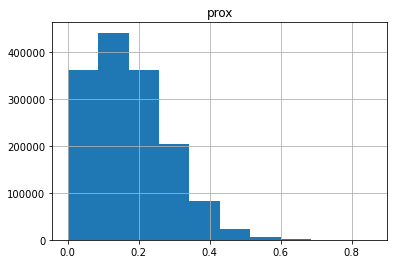

In [11]:
edge_list_1719[["prox"]].hist(); # como se distribuye nuestra medida de proximidad
# esto ya lo hice para todos en el notebook Visualización de matrices de proximidad, solo para chequear 

In [12]:
# cantidad de valores = 0 
sum(i == 0.0 for i in edge_list_1719[["prox"]].unstack()) / sum(i < 1.0 for i in edge_list_1719[["prox"]].unstack())* 100 

8.293960558751028

In [13]:
# cantidad de valores menores a 0.1
sum(i < 0.1 for i in edge_list_1719[["prox"]].unstack()) / sum(i < 1.0 for i in edge_list_1719[["prox"]].unstack())* 100 

28.005665354841504

In [14]:
# cantidad de valores menores a 0.2
sum(i < 0.2 for i in edge_list_1719[["prox"]].unstack()) / sum(i < 1.0 for i in edge_list_1719[["prox"]].unstack())* 100 

61.73385265752713

In [15]:
# número máximo de links
max_links = (prox_matrix1['1719'].shape[0]*prox_matrix1['1719'].shape[0]-prox_matrix1['1719'].shape[0])//2 
max_links

739936

**numpy.tril_indices(n, k=0, m=None)**

Devuelve los índices del triángulo inferior de una matriz (n, m). Por lo que, para los cálculos sólo se toman los valores del triángulo inferior. 

[source](https://numpy.org/doc/stable/reference/generated/numpy.tril_indices.html)

In [16]:
# pruebo con un ejemplo para luego escalar
X = prox_matrix1['1719']

In [17]:
X

,101,102,103,104,105,106,201,202,203,204,...,9615,9616,9617,9618,9701,9702,9703,9704,9705,9706
product_i,,,,,,,,,,,,,,,,,,,,,
101,1.000000,0.250000,0.277778,0.142857,0.266667,0.228571,0.454545,0.352941,0.294118,0.352941,...,0.058824,0.058824,0.000000,0.294118,0.294118,0.294118,0.235294,0.470588,0.352941,0.235294
102,0.250000,1.000000,0.416667,0.361111,0.444444,0.388889,0.444444,0.194444,0.222222,0.250000,...,0.027778,0.083333,0.027778,0.166667,0.055556,0.027778,0.083333,0.166667,0.111111,0.083333
103,0.277778,0.416667,1.000000,0.190476,0.300000,0.285714,0.409091,0.055556,0.388889,0.166667,...,0.000000,0.111111,0.055556,0.222222,0.000000,0.055556,0.000000,0.222222,0.055556,0.055556
104,0.142857,0.361111,0.190476,1.000000,0.433333,0.285714,0.181818,0.095238,0.095238,0.238095,...,0.000000,0.095238,0.000000,0.142857,0.047619,0.000000,0.095238,0.047619,0.142857,0.142857
105,0.266667,0.444444,0.300000,0.433333,1.000000,0.485714,0.366667,0.166667,0.333333,0.166667,...,0.033333,0.100000,0.033333,0.266667,0.100000,0.066667,0.166667,0.133333,0.300000,0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9702,0.294118,0.027778,0.055556,0.000000,0.066667,0.057143,0.045455,0.066667,0.076923,0.066667,...,0.142857,0.000000,0.000000,0.125000,0.500000,1.000000,0.384615,0.285714,0.333333,0.363636
9703,0.235294,0.083333,0.000000,0.095238,0.166667,0.142857,0.136364,0.200000,0.153846,0.066667,...,0.000000,0.153846,0.000000,0.187500,0.461538,0.384615,1.000000,0.214286,0.384615,0.538462
9704,0.470588,0.166667,0.222222,0.047619,0.133333,0.085714,0.227273,0.200000,0.214286,0.333333,...,0.000000,0.000000,0.000000,0.187500,0.142857,0.285714,0.214286,1.000000,0.357143,0.142857


In [18]:
# sorted(X.values[np.tril_indices(X.shape[0],-1)]) # paso la matriz a una dimensión -solo la mitad de la matriz, sin repeticiones- y la ordeno 

In [19]:
int(0.1*(X.shape[0]*X.shape[0]-X.shape[0])//2) # para calcular a distintas desidades, el numero de enlaces

73993

In [20]:
# para calcular los umbrales de proximidad según la densidad de aristas definidas -ej. con densidad = 0.1-
sorted(X.values[np.tril_indices(X.shape[0],-1)])[int(0.1*(X.shape[0]*X.shape[0]-X.shape[0])//2)] 

0.04

### Pruebo armar grafos a distintas densidades de aristas

Cabe recordar, que en el paper original utilizan como umbral proximidades mayores a 0.55 para representar.

Para ofrecer una visualización en la que se incluyen todos los productos (en ese caso 775), llegan a todos los nodos calculando el árbol de expansión máxima, que incluye los 774 enlaces maximizando la proximidad agregada del árbol y superpuestos sobre él todos los enlaces con una proximidad mayor a 0.55. Ese conjunto de 1525 enlaces se utiliza para visualizar la estructura de la matriz de proximidad completa, que está lejos de ser homogénea y parece tener una estructura centro-periferia.

In [29]:
def grafos_pordensidad_dict(proximity_matrix:pd.DataFrame, densities:list):
    """
        Toma un dataframe cuadrado (x,x) y una lista de densidades y devuelte
        un diccionario en el que cada densidad es la key y cada value es la
        matriz de adyacencia generada a partir de utilizar la densidad 
        correspondiente como umbral.
        
        Atributos
        ---------
        
        proximity_matrix: pd.DataFrame
            Matriz de proximidades.
            
        densities: list
            Lista de densidades para utilizar como umbrales.
            
        Returns
        -------
        
        Gs: dict
            Diccionario con las densidades como keys y las matrices de 
            adyacencia correspondientes como values.
            
    """
    # cantidad de filas de la matriz (es una matriz cuadrada, así que filas==columnas)
    n = proximity_matrix.shape[0]
    # máxima cantidad de links
    max_links = (n*n-n)//2 
    # conservo la mitad de la matriz ya que es simétrica (me quedo con triangulo inferior)
    tril_idx = np.tril_indices(n,-1) 
    # paso a una dimensión y ordeno
    sorted_proximities = sorted(proximity_matrix.values[tril_idx].flatten(),reverse=True)
    
    # genero grafos y los guardo en diccionario
    Gs = dict()
    for d in densities:
        # pruebo con distinto número de links en base a la densidad definida
        idx = int(d*max_links) 
        # calculo el umbral correspondiente a dicha densidad
        threshold = sorted_proximities[idx] 
        # armo grafos a distintos umbrales
        Gs[threshold] = nx.from_pandas_adjacency(proximity_matrix>=threshold) 
    return Gs

### <span style="color:steelblue">Dataset 1: </span>: todos los períodos - 109 países

In [87]:
# pruebo con densidades base
densidades =  np.arange(0, 1, 0.1)
densidades 

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [88]:
graphs_ = {}
for year in list_years1:
    df_ = prox_matrix1[year]
    Gs_ = grafos_pordensidad_dict(df_, densidades)
    graphs_[year] = Gs_

In [89]:
graphs_

{'1719': {0.8571428571428571: <networkx.classes.graph.Graph at 0x25352b03250>,
  0.3214285714285714: <networkx.classes.graph.Graph at 0x25352b03430>,
  0.2631578947368421: <networkx.classes.graph.Graph at 0x25352b03f10>,
  0.2222222222222222: <networkx.classes.graph.Graph at 0x25352b03940>,
  0.1875: <networkx.classes.graph.Graph at 0x25352b03730>,
  0.1578947368421052: <networkx.classes.graph.Graph at 0x25352b035b0>,
  0.1333333333333333: <networkx.classes.graph.Graph at 0x25352b038b0>,
  0.1034482758620689: <networkx.classes.graph.Graph at 0x25352b03fd0>,
  0.0714285714285714: <networkx.classes.graph.Graph at 0x25352b035e0>,
  0.04: <networkx.classes.graph.Graph at 0x25352b03cd0>},
 '0709': {0.90625: <networkx.classes.graph.Graph at 0x25352b03040>,
  0.3333333333333333: <networkx.classes.graph.Graph at 0x25352b03e50>,
  0.2666666666666666: <networkx.classes.graph.Graph at 0x25352b03c40>,
  0.2222222222222222: <networkx.classes.graph.Graph at 0x25352b03640>,
  0.1914893617021276: <net

In [93]:
def plot_heatmaps_dict(graphs_dict:dict, save:bool=False):
    """
        Toma un diccionario que tenga como keys los nombres de los periodos y
        como values, otro diccionario. Este segundo dict tiene como keys los
        umbrales de proximidad que se obtuvieron al probar las distintas densidades 
        a partir de las cuales se generaron los grafos.
        Ejemplo: { '1719': { 0.857: graph, 0.321: graph, ... } }
        Y genera un heatmap de cada periodo.
        
        Atributos
        ---------
        
        graphs_dict: dict
            Diccionario de grafos.
            
        save: bool, default=False
            Indicador para guardar el gráfico o plotearlo.
            
    """
    ncols = 5
    for year, Gs in graphs_dict.items():
        dmin, dmax = np.min(list(Gs.keys())), np.max(list(Gs.keys()))
        nrows = ceil(len(Gs)/ncols)
        fig, axs = plt.subplots(nrows, ncols, figsize=(20,20))
        fig.suptitle(f'Periodo: {year}', fontsize=24)
        densities = list(Gs.keys())
        r,i = 0,0
        while r<nrows  and i < len(densities):
            c = 0
            while c < ncols and i<len(densities):
                d = densities[i]
                sns.heatmap(nx.to_numpy_array(Gs[d]),cbar=False,cmap="Blues",square=True, ax=axs[r,c])
                axs[r,c].set_title('Proximity threshold: {:0.3}'.format(d))
                i += 1
                c += 1
            r += 1
        plt.tight_layout()
        plt.subplots_adjust(top=0.98)
        if save:
            folder = os.path.abspath('.').replace('notebooks','figures')
            file_path = os.path.join(folder, 'heatmap_{0}_{1:0.3}-{2:0.3}.png'.format(year,dmin,dmax))
            plt.savefig(file_path)
            plt.close()
            print(f'{file_path} guardado exitosamente.')
        else:
            plt.show()

In [94]:
plot_heatmaps_dict(graphs_, save=True)

C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\heatmap_1719_0.04-0.857.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\heatmap_0709_0.0435-0.906.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\heatmap_9799_0.0476-0.9.png guardado exitosamente.


In [64]:
def find_shortest_path(graph:nx.Graph):
    """
        Toma un grafo de networkx e intenta calcular el promedio del camino más
        corto.
        Si el grafo no está completamente conectado, calcula todos los
        promedios de caminos más cortos de los subgrafos que sí lo están  y
        devuelve el máximo valor de entre estos promedios.
        
        Atributos
        ---------
        
        graph: nx.Graph
            Grafo de netwrokx.
        
        Returns
        -------
        
        shortest: float
            Promedio de caminos más cortos.
    """
    try:
        shortest = nx.average_shortest_path_length(graph)
    except:
        components_path_length = list()
        for C in (graph.subgraph(c).copy() for c in nx.connected_components(graph)):
            components_path_length.append(nx.average_shortest_path_length(C))
        shortest = np.max(components_path_length)
    return shortest

In [102]:
graphs_['1719'].values()

dict_values([<networkx.classes.graph.Graph object at 0x0000025352B03250>, <networkx.classes.graph.Graph object at 0x0000025352B03430>, <networkx.classes.graph.Graph object at 0x0000025352B03F10>, <networkx.classes.graph.Graph object at 0x0000025352B03940>, <networkx.classes.graph.Graph object at 0x0000025352B03730>, <networkx.classes.graph.Graph object at 0x0000025352B035B0>, <networkx.classes.graph.Graph object at 0x0000025352B038B0>, <networkx.classes.graph.Graph object at 0x0000025352B03FD0>, <networkx.classes.graph.Graph object at 0x0000025352B035E0>, <networkx.classes.graph.Graph object at 0x0000025352B03CD0>])

In [104]:
# centralidad        
degree_centrality_ = [nx.degree_centrality(G) for G in list(graphs_['1719'].values())]
avg_degree_centrality_ = [np.mean(list(i.values())) for i in degree_centrality_]

In [108]:
betweenness_centrality_ = [nx.betweenness_centrality(G) for G in list(graphs_['1719'].values())]
avg_betweenness_centrality_ = [np.mean(list(i.values())) for i in betweenness_centrality_]

In [107]:
closeness_centrality_ = [nx.closeness_centrality(G) for G in list(graphs_['1719'].values())]
avg_closeness_centrality_ = [np.mean(list(i.values())) for i in closeness_centrality_]

In [109]:
eigenvector_centrality_ = [nx.eigenvector_centrality(G, max_iter=1000) for G in list(graphs_['1719'].values())]
avg_eigenvector_centrality_ = [np.mean(list(i.values())) for i in eigenvector_centrality_]

In [110]:
# grado promedio
max_degree_ = [np.max(list(dict(G.degree()).values())) for G in list(graphs_['1719'].values())]
# camino mínimo
avg_shortest_path_length_ = [find_shortest_path(G) for G in list(graphs_['1719'].values())]

In [111]:
# coeficiente de clustering
avg_clustering_ = [nx.average_clustering(G) for G in list(graphs_['1719'].values())]

In [112]:
measures = {}
df = pd.DataFrame({'d':list(graphs_['1719'].keys()),
                   'avg_degree_centrality':avg_degree_centrality_,
                   'avg_betweenness_centrality':avg_betweenness_centrality_,
                   'avg_closeness_centrality_':avg_closeness_centrality_,
                   'max_degree':max_degree_,
                   'avg_shortest_path':avg_shortest_path_length_,
                   'avg_clustering':avg_clustering_})
measures['1719'] = df

In [ ]:
measures['1719']

In [100]:
def calculate_graphs_measures(graphs_dict:dict):
    """
        Toma un diccionario que tenga como keys los nombres de los estadíos y
        como values, otro diccionario. Este segundo dict tiene como keys las
        densidades a partir de las cuales se generaron los grafos.
        Ejemplo: { '1719': { 0.05: graph, 0.1: graph, ... } }
        Y calcula medidas de centralidad, clustering, grado y camino más corto
        promedio para cada estadío y cada densidad.

        Atributos
        ---------
        
        graphs_dict: dict
            Diccionario de grafos.
            
        Returns
        -------
        
        measures: dict
            Diccionario con periodos como keys y dataframes de resumen como
            values.
            
    """
    measures = {}
    for year, Gs in graphs_dict.items():
        # centralidad
        degree_centrality_ = [nx.degree_centrality(G) for G in list(Gs.values())]
        avg_degree_centrality_ = [np.mean(list(i.values())) for i in degree_centrality_]
        betweenness_centrality_ = [nx.betweenness_centrality(G) for G in list(Gs.values())]
        avg_betweenness_centrality_ = [np.mean(list(i.values())) for i in betweenness_centrality_]
        closeness_centrality_ = [nx.closeness_centrality(G) for G in list(Gs.values())]
        avg_closeness_centrality_ = [np.mean(list(i.values())) for i in closeness_centrality_]
        eigenvector_centrality_ = [nx.eigenvector_centrality(G, max_iter=1000) for G in list(Gs.values())]
        avg_eigenvector_centrality_ = [np.mean(list(i.values())) for i in eigenvector_centrality_]
        # grado promedio
        max_degree_ = [np.max(list(dict(G.degree()).values())) for G in list(Gs.values())]
        # camino mínimo
        avg_shortest_path_length_ = [find_shortest_path(G) for G in list(Gs.values())]
        # ceficiente de clustering
        avg_clustering_ = [nx.average_clustering(G) for G in list(Gs.values())]
        df = pd.DataFrame({'d':list(Gs.keys()),
                           'avg_degree_centrality':avg_degree_centrality_,
                           'avg_betweenness_centrality':avg_betweenness_centrality_,
                           'avg_closeness_centrality_':avg_closeness_centrality_,
                           'max_degree':max_degree_,
                           'avg_shortest_path':avg_shortest_path_length_,
                           'avg_clustering':avg_clustering_})
        measures[year] = df
    return measures

In [113]:
# measures = calculate_graphs_measures(graphs_)

In [114]:
measures

{'1719':           d  avg_degree_centrality  avg_betweenness_centrality  \
 0  0.857143               0.001649                3.336959e-09   
 1  0.321429               0.101659                9.786966e-04   
 2  0.263158               0.207169                7.088590e-04   
 3  0.222222               0.307996                5.806742e-04   
 4  0.187500               0.410000                4.885630e-04   
 5  0.157895               0.511829                4.027665e-04   
 6  0.133333               0.605370                3.267683e-04   
 7  0.103448               0.703349                2.455279e-04   
 8  0.071429               0.814065                1.543866e-04   
 9  0.040000               0.902683                8.144960e-05   
 
    avg_closeness_centrality_  max_degree  avg_shortest_path  avg_clustering  
 0                   0.000006           5           1.500000        0.000000  
 1                   0.460164         415           2.195003        0.412268  
 2              

In [117]:
def plot_measures(measures_dict:dict, save:bool=False):
    """
        Toma un diccionario con periodos como keys y dataframes con medidas de centralidad como
        values y genera los gráficos para visualizar dichas medidas.
        
        Atributos
        ---------
        
        measures_dict: dict
            Diccionario con dataframes.
            
        save: bool, default=False
            Indicador para guardar el gráfico o plotearlo.
            
    """
    fig = plt.figure(figsize=(20,10))
    measures_list = list(list(measures_dict.values())[0].columns.drop('d'))
    dmin, dmax = np.min(list(measures_dict.values())[0].d), np.max(list(measures_dict.values())[0].d)
    i=1
    for measure in measures_list:
        plt.subplot(2,3,i)
        for year, df in measures_dict.items():
            plt.plot(df.d, df[measure], label=year)
            measure_plot = measure.replace('_',' ')
            plt.title(measure_plot.title())
            plt.xlabel('Edges density')
            plt.ylabel(measure_plot.upper())
            plt.legend()
        i+=1
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    if save:
        folder = os.path.abspath('.').replace('notebooks','figures')
        file_path = os.path.join(folder, 'measures_{0:0.3}-{1:0.3}.png'.format(dmin,dmax))
        plt.savefig(file_path)
        plt.close()
        print(f'{file_path} guardado exitosamente.')
    else:
        plt.show()

In [118]:
plot_measures(measures, save=True)

C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\measures_0.04-0.857.png guardado exitosamente.


In [131]:
def plot_graphs_by_density(graphs_dict:dict, list_years:list, save:bool=False):
    """
        Toma un diccionario que tenga como keys los nombres de los periodos y
        como values, otro diccionario. Este segundo dict tiene como keys las
        densidades a partir de las cuales se generaron los grafos.
        Ejemplo: { '1719': { 0.05: graph, 0.1: graph, ... } }
        Y grafica cada grafo por densidad.

        Atributos
        ---------
        
        graphs_dict: dict
            Diccionario de grafos.
        
        list_years: list
            Lista 
        
        save: bool, default=False
            Indicador para guardar el gráfico o plotearlo.
            
    """
    ncols = 2
    nrows = 2
    colors = sns.color_palette("viridis")
    color_map = dict(zip(list(graphs_dict.keys()), colors))

    for y, year in enumerate(list_years):
            fig = plt.figure(figsize=(15,10))
            fig.suptitle('Densidad: {:0.3} - Grafo con layout Spring'.format(d), fontsize=20)
            i = 1        
            G = graphs_dict[year][d]
            plt.subplot(nrows, ncols, i)
            pos = nx.spring_layout(G,k=0.2,seed=2020)
            nx.draw(G,pos=pos, with_labels=True, font_weight='bold', 
                    node_color=np.array([color_map[year]]), alpha=0.5)
            plt.title(f'Periodo: {year}')
            i+=1
        plt.tight_layout()
        plt.subplots_adjust(top=0.95)
        if save:
            folder = os.path.abspath('.').replace('notebooks','figures')
            file_path = os.path.join(folder, 'graph_by_density_{:0.3}.png'.format(d))
            plt.savefig(file_path)
            plt.close()
            print(f'{file_path} guardado exitosamente.')
        else:
            plt.show()

In [158]:
plot_graphs_by_density(graphs_, list_years1, save=True)

In [159]:
def plot_graphs_by_period(graphs_dict:dict, save:bool=False):
    """
        Toma un diccionario que tenga como keys los nombres de los periodos y
        como values, otro diccionario. Este segundo dict tiene como keys los umbrales 
        a partir de las cuales se generaron los grafos.
        
        Atributos
        ---------
        graphs_dict: dict
            Diccionario de grafos.
            
        save: bool, default=False
            Indicador para guardar el gráfico o plotearlo.
            
    """
    n_densities = len(list(graphs_dict.values())[0])
    ncol = 2
    nrow = ceil(n_densities/ncol)

    colors = sns.color_palette("winter",n_densities)
    color_map = dict(zip(list(list(graphs_dict.values())[0].keys()), colors))

    for year, Gs in graphs_dict.items():
        fig = plt.figure(figsize=(20,30))
        fig.suptitle(f'Periodo: {year} - Grafo con layout Spring', fontsize=20)
        i = 1
        for d, G in Gs.items():
            plt.subplot(nrow,ncol,i)
            pos = nx.spring_layout(G,k=0.2,seed=2020)
            nx.draw(G,pos=pos, with_labels=True, font_weight='bold',
            node_color=np.array([color_map[d]]), alpha=0.5)
            plt.title('Threshold: {:0.3}'.format(d))
            i += 1
        plt.tight_layout()
        plt.subplots_adjust(top=0.95)
        if save:
            folder = os.path.abspath('.').replace('notebooks','figures')
            file_path = os.path.join(folder, f'graph_by_period_{year}.png')
            plt.savefig(file_path)
            plt.close()
            print(f'{file_path} guardado exitosamente.')
        else:
            plt.show()

C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\graph_by_period_1719.png guardado exitosamente.


KeyError: 0.90625

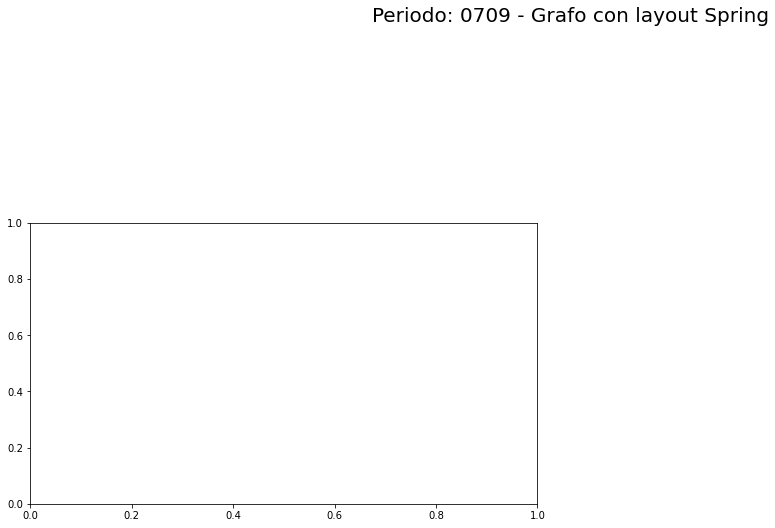

In [160]:
plot_graphs_by_period(graphs_, save=True)
# modificar este codigo para que las d se actualicen con los datos de cada período 

In [161]:
def generate_random_graphs(graphs_dict:dict):
    """
        Toma un diccionario que tenga como keys los nombres de los periodos y
        como values, otro diccionario. Este segundo dict tiene como keys los
        umbrales a partir de los cuales se generaron los grafos.
        Y genera un diccionario con las mismas características pero en el cual
        los grafos son aleatorios y preservan la misma distribución de nodos y
        aristas.

        Atributos
        ---------
        
        graphs_dict: dict
            Diccionario de grafos.

        Returns
        -------

        random_graphs: dict
            Diccionario de grafos aleatorios.
    """
    random_graphs = dict()
    for year, Gs_dict in graphs_dict.items():
        densities = list(Gs_dict.keys())
        random_graphs[year] = {d: nx.gnm_random_graph(G.number_of_nodes(), G.number_of_edges(), seed = densities.index(d)) for d, G in Gs_dict.items()}
    return random_graphs

In [163]:
random_graphs = generate_random_graphs(graphs_)

In [171]:
def plot_distribution_comparisson(original_graphs, random_graphs, save:bool=False):
    """
        TODO
    """
    for year, Gs_dict in original_graphs.items():
        for d, G in Gs_dict.items():
            fig = plt.figure(figsize=(8,3))
            fig.suptitle('Periodo: {0} - Umbral {1:0.3}'.format(year, d), fontsize=14)
            graphs_degree = pd.DataFrame(G.degree,columns=['Node','Degree']).set_index('Node')
            graphs_degree.hist(bins=8,density=True,ax=plt.subplot(121),label='Grafo original')
            plt.legend()
            random = random_graphs[year][d]
            random_degree = pd.DataFrame(random.degree,columns=['Node','Degree']).set_index('Node')
            random_degree.hist(bins=8,density=True,ax=plt.subplot(122),label='Random')
            plt.legend()
            plt.tight_layout()
            plt.subplots_adjust(top=0.85)
            if save:
                folder = os.path.abspath('.').replace('notebooks','figures')
                file_path = os.path.join(folder, 'dist_comparisson_{0}_{1:0.3}.png'.format(year, d))
                plt.savefig(file_path)
                plt.close()
                print(f'{file_path} guardado exitosamente.')
            else:
                plt.show()

In [172]:
plot_distribution_comparisson(graphs_, random_graphs, save=True)

C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\dist_comparisson_1719_0.857.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\dist_comparisson_1719_0.321.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\dist_comparisson_1719_0.263.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\dist_comparisson_1719_0.222.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\dist_comparisson_1719_0.188.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\dist_comparisson_1719_0.158.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\dist_comparisson_1719_0.133.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\dist_comparisson_1719_0.103.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\dist_comparisson_1719_0.0714.png guard

In [173]:
def calculate_louvain_communities(graphs_dict:dict):
    """
        Toma un diccionario que tenga como keys los nombres de los periodos y
        como values, otro diccionario. Este segundo dict tiene como keys los
        umbrales a partir de los cuales se generaron los grafos.
        Y genera un diccionario con las medidas de modularidad de comunidades 
        de louvain (Q, NC, comunidades).

        Atributos
        ---------
        
        graphs_dict: dict
            Diccionario de grafos.

        Returns
        -------

        : dict
            Diccionario de medidas.
    """
    louvain_modularities = dict()
    for key, Gs_dict in graphs_dict.items():
        louvain_modularities[key] = dict()
        for d, G in Gs_dict.items():
            modulos = community_louvain.best_partition(G,random_state=55)
            Q = community_louvain.modularity(partition=modulos, graph=G)
            NC = len(set(modulos.values()))
            louvain_modularities[key][d] = {'G':G,'Q':Q, 'NC':NC,'communities':modulos}
    return louvain_modularities

In [176]:
louv_communities = calculate_louvain_communities(graphs_)

In [177]:
def plot_communities_by_density(community_dict:dict, save:bool=False):
    """
        TODO
    """    
    densities = list(list(community_dict.values())[0].keys())
    
    ncols = 2
    nrows = 2

    for d in densities:
        fig = plt.figure(figsize=(15,10))
        fig.suptitle('Densidad: {:0.3} - Grafo con layout Spring'.format(d), fontsize=20)
        i = 1
        
        for estadio in community_dict.keys():
            G = community_dict[estadio][d]['G']
            plt.subplot(nrows, ncols, i)
            pos = nx.spring_layout(G,k=0.2,seed=2020)
            modulos = community_dict[estadio][d]['communities']
            values = [v for n,v in modulos.items()]
            NC, Q = community_dict[estadio][d]['NC'],community_dict[estadio][d]['Q']
            nx.draw(G,pos=pos, with_labels=True,cmap=plt.cm.tab10,font_weight='bold',node_color = values, font_color='white', edge_color='gray')
            plt.title('Estadío: {0} - NC: {1} - Q: {2:0.3}'.format(estadio,NC,Q))
            i += 1
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        if save:
            folder = os.path.abspath('.').replace('notebooks','graphs')
            file_path = os.path.join(folder, 'community_by_density_{:0.3}.png'.format(d))
            plt.savefig(file_path)
            plt.close()
            print(f'{file_path} guardado exitosamente.')
        else:
            plt.show()

KeyError: 0.8571428571428571

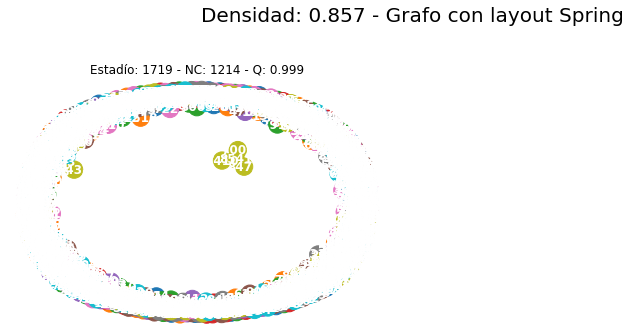

In [178]:
plot_communities_by_density(louv_communities, save=True)

In [ ]:
def plot_communities_by_stage(community_dict:dict, save:bool=False):
    """
        TODO
    """    
    n_densities = len(list(community_dict.values())[0].keys())
    
    ncols = 2
    nrows = ceil(n_densities/ncols)
    
    for estadio, Gs_info in community_dict.items():
        fig = plt.figure(figsize=(20,30))
        fig.suptitle(f'Estadío: {estadio} - Grafo con layout Spring', fontsize=20)
        i = 1
        
        for d in Gs_info.keys():
            G = Gs_info[d]['G']
            plt.subplot(nrows, ncols, i)
            pos = nx.spring_layout(G,k=0.2,seed=2020)
            modulos = Gs_info[d]['communities']
            values = [v for n,v in modulos.items()]
            NC, Q = Gs_info[d]['NC'],Gs_info[d]['Q']
            nx.draw(G,pos=pos, with_labels=True,cmap=plt.cm.tab10,font_weight='bold',node_color = values, font_color='white', edge_color='gray')
            plt.title('Edge Density: {0:0.3} - NC: {1} - Q: {2:0.2}'.format(d,NC,Q))
            i += 1
        plt.tight_layout()
        plt.subplots_adjust(top=0.95)
        if save:
            folder = os.path.abspath('.').replace('notebooks','graphs')
            file_path = os.path.join(folder, f'community_by_stage_{estadio}.png')
            plt.savefig(file_path)
            plt.close()
            print(f'{file_path} guardado exitosamente.')
        else:
            plt.show()

In [ ]:
def plot_modularity_measures_NXvsW(graphs_communities, random_communities=None, errorbar=False,
                                    title:str=None,
                                    save:bool=False, file_name:str='modularity_measures_NXvsW.png'):
    """
        Plotea NC y Q.
    """
    measures = {'Q':[0.1,1],'NC':[0,50], 'Q_pvalue_y':0.2, 'NC_pvalue_y':3}
    stages = {'N1':'green','N2':'blue','N3':'red'}
    fig = plt.figure(figsize=(15,8))
    if title:
        fig.suptitle(title, fontsize=20)
    i = 1
    for m in ['Q','NC']:
        for s in stages.keys():
            densities = list(graphs_communities[s].keys())
            ax = plt.subplot(2,3,i)
            ax.set_ylim(measures[m])
            plt.title(f'{m.upper()} - {s} vs. W',fontsize=16)
            if errorbar:
                nx_avg = [graphs_communities[s][d][m+'_avg'] for d in densities]
                nx_se = [graphs_communities[s][d][m+'_sem'] for d in densities]
                w_avg = [graphs_communities['W'][d][m+'_avg'] for d in densities]
                w_se = [graphs_communities['W'][d][m+'_sem'] for d in densities]
                pvalues = [graphs_communities[s][d][m+'_pvalue'] for d in densities]
                plt.errorbar(densities, nx_avg, nx_se, label=s, color=stages[s])
                plt.errorbar(densities, w_avg, w_se,label='W', color='black')
                signif = [i for i,p in enumerate(pvalues) if p<0.05]        # acá me quedo con los índices de los p-valores menores a 
                signif_dens = [densities[p] for p in signif]
                plt.scatter(signif_dens, [measures[m+'_pvalue_y']]*len(signif_dens), marker='*',color='black')
                plt.legend(loc='upper right')
            else:
                values = [graphs_communities[s][d][m] for d in densities]
                W_values = [graphs_communities['W'][d][m] for d in densities]
                plt.plot(densities, values, label=s, color=stages[s])
                plt.plot(densities, W_values, label='W', color='black')
                plt.legend(loc = "lower left", fontsize='large')
            plt.xlabel('Densidad (d)')    
            plt.ylabel(m)
            if random_communities:
                # this is an inset axes over the main axes
                random_values = [random_communities[s][d][m] for d in random_communities[s].keys()]
                random_W_values = [random_communities['W'][d][m] for d in random_communities['W'].keys()]
                ins = ax.inset_axes([0.6, 0.6, 0.3, 0.3])
                ins.set_title('Random')
                ins.plot(densities, random_values, label=s, color = stages[s])
                ins.plot(densities, random_W_values, label='W' , color = "black")
                ins.set_xlabel('d')
                ins.set_ylabel(m)
                ins.set_ylim(measures[m])
            i += 1
    plt.tight_layout()
    if title:
        plt.subplots_adjust(top=0.90)
    if save:
        folder = os.path.abspath('.').replace('notebooks','graphs')
        file_path = os.path.join(folder, file_name)
        plt.savefig(file_path)
        plt.close()
        print(f'{file_path} guardado exitosamente.')
    else:
        plt.show()
        
def plot_modularity_measures_by_stage_vsRandom(graphs_communities, random_communities=None, save:bool=False, 
                                               file_name:str='modularity_measures_by_stage_vsRandom.png'):
    """
        Plotea NC y Q.
    """
    measures = {'Q':'blue','NC':'green'}
    fig = plt.figure(figsize=(15,8))
    i = 1
    for m in measures:
        for s in graphs_communities.keys():
            densities = list(graphs_communities[s].keys())
            values = [graphs_communities[s][d][m] for d in graphs_communities[s].keys()]
            random_values = [random_communities[s][d][m] for d in random_communities[s].keys()]
            ax = plt.subplot(2,4,i)
            plt.title(f'{m.upper()} - {s} vs. Random',fontsize=16)
            plt.plot(densities, values, label=s, color=measures[m])
            plt.plot(densities, random_values, label='Random', color='black')
            plt.legend()
            plt.xlabel('Densidad (d)')    
            plt.ylabel(m)
            i += 1
    plt.tight_layout()
    if save:
        folder = os.path.abspath('.').replace('notebooks','graphs')
        file_path = os.path.join(folder, file_name)
        plt.savefig(file_path)
        plt.close()
        print(f'{file_path} guardado exitosamente.')
    else:
        plt.show()


def plot_modularity_measures_NXvsW_for_subjects(suj_graphs_communities, save:bool=False):
    """
        TODO
    """    
    measures = {'NC':'green','Q':'blue'}
    stages = ['N1','N2','N3']
    n_suj = len(list(suj_graphs_communities.keys()))
    ncols = 6
    nrows = ceil(n_suj/ncols)
    
    for m in measures:
        for s in stages:
            fig = plt.figure(figsize=(15,8))
            fig.suptitle(f'{m} - {s}', fontsize=20)
            i = 1
            for i in range(i, n_suj+1):      #aclaración: no itero sobre las keys porque no van a estar en orden, esto me garantiza: suj1, suj2, suj3 y no suj1, suj10
                suj,suj_name = f'suj{i}', f'Sujeto {i}'
                suj_info = suj_graphs_communities[suj]
                densities = list(list(suj_info.values())[0].keys())
                nx_values = [suj_info[s][d][m] for d in densities]
                w_values = [suj_info['W'][d][m] for d in densities]
                ax = plt.subplot(nrows,ncols,i)
                plt.title(suj_name, fontsize=16)
                plt.plot(densities, nx_values, label=s, color=measures[m])
                plt.plot(densities, w_values, label='W', color='black')
                plt.legend()
                plt.xlabel('Densidad (d)')    
                plt.ylabel(m)
                i += 1            
            plt.tight_layout()
            plt.subplots_adjust(top=0.90)
            if save:
                folder = os.path.abspath('.').replace('notebooks','graphs')
                file_path = os.path.join(folder, f'modularity_measures_for_subjects_{m}_{s}.png')
                plt.savefig(file_path)
                plt.close()
                print(f'{file_path} guardado exitosamente.')
            else:
                plt.show()


def avg_modularity_measures_from_suj(suj_modularity_measures):
    """
        Calcula el promedio de las medidas de modularidad en base a los sujetos.
    """
    suj_measures = dict()
    for suj in suj_modularity_measures.keys():
        for stage in suj_modularity_measures[suj].keys():
            if stage not in suj_measures.keys():
                suj_measures[stage] = {d:{'NC':[],'Q':[]} for d in suj_modularity_measures[suj][stage].keys()}
            for d in suj_modularity_measures[suj][stage].keys():
                suj_measures[stage][d]['NC'].append(suj_modularity_measures[suj][stage][d]['NC'])
                suj_measures[stage][d]['Q'].append(suj_modularity_measures[suj][stage][d]['Q'])
    
    avg_n_sem = dict()
    for stage in suj_measures.keys():
        avg_n_sem[stage] = dict()
        for delta in suj_measures[stage].keys():
            avg_n_sem[stage][delta] = dict()
            for measure, data in suj_measures[stage][delta].items():
                avg_n_sem[stage][delta].update({measure+'_avg':np.mean(data)})
                avg_n_sem[stage][delta].update({measure+'_sem':sem(data)})
                if stage != 'W':
                    w = suj_measures['W'][delta][measure]
                    anova = ttest_rel(data,w)
                    avg_n_sem[stage][delta].update({measure+'_pvalue':anova.pvalue})
    
    return avg_n_sem


def calculate_ari_for_stages(suj_graphs_communities:dict, stages:list):
    SUJS = list(suj_graphs_communities.keys())
    suj_comb = list(combinations(SUJS, 2))

    ari_results = dict()
    for sc in suj_comb:
        ari_results[sc] = dict()
        suj_a = sc[0]
        suj_b = sc[1]
        for stg in stages:
            ari_results[sc][stg] = dict()
            for d in suj_graphs_communities[suj_a][stg].keys():
                values_a = list(suj_graphs_communities[suj_a][stg][d]['communities'].values())
                values_b = list(suj_graphs_communities[suj_b][stg][d]['communities'].values())
                ari = adjusted_rand_score(values_a, values_b)
                ari_results[sc][stg][d] = ari
    return ari_results


def calculate_ari_avg_n_se(sujs_comb_ari_dict):
    stages = list(sujs_comb_ari_dict.values())[0].keys()
    densities = list(list(sujs_comb_ari_dict.values())[0].values())[0].keys()
    
    ari_avg_std = dict()
    for stg in stages:
        ari_avg_std[stg] = dict()
        for d in densities:
            values = [sujs_comb_ari_dict[sc][stg][d] for sc in sujs_comb_ari_dict.keys()]
            ari_avg_std[stg][d] = {'avg': np.mean(values), 'se': sem(values)}
    return ari_avg_std


def plot_ari_errorbar_NXvsW(suj_nx_ari, suj_w_ari,
                            title:str=None,
                            save:bool=False, file_name:str='ari_errorbar_avg_se.png'):
    stages = {'N1':'green','N2':'blue','N3':'red'}
    fig = plt.figure(figsize=(15,8))
    if title:
        fig.suptitle(title, fontsize=20)
    i = 1
    for st in suj_nx_ari.keys():
        densities = list(suj_nx_ari[st].keys())
        nx_avg = [suj_nx_ari[st][d]['avg'] for d in densities]
        w_avg = [suj_w_ari['W'][d]['avg'] for d in densities]
        nx_se = [suj_nx_ari[st][d]['se'] for d in densities]
        w_se = [suj_w_ari['W'][d]['se'] for d in densities]
        ax = plt.subplot(2,3,i)
        plt.title(f'ARI - {st} vs. W',fontsize=16)
        plt.errorbar(densities, nx_avg, nx_se, label=st, color=stages[st])
        plt.errorbar(densities, w_avg, w_se,label='W', color='black')
        plt.legend()
        plt.xlabel('Densidad (d)')    
        plt.ylabel('ARI')
        i += 1         
    plt.tight_layout()
    if title:
        plt.subplots_adjust(top=0.90)
    if save:
        folder = os.path.abspath('.').replace('notebooks','graphs')
        file_path = os.path.join(folder, file_name)
        plt.savefig(file_path)
        plt.close()
        print(f'{file_path} guardado exitosamente.')
    else:
        plt.show()


def generate_permutations(suj_graphs, start,stop):
    graphs_list = list()
    for suj in suj_graphs.keys():
        for stage in suj_graphs[suj].keys():
            for d in suj_graphs[suj][stage].keys():
                communities = suj_graphs[suj][stage][d]['communities']
                graphs_list.append({'sujeto':suj,
                                    'estadio':stage,
                                    'densidad':d,
                                    'nodes_order':list(communities.keys()),
                                    'communities':list(communities.values())})
    df = pd.DataFrame(graphs_list)
    permutation = range(start,stop)
    for i in permutation:
        col_name = f'perm_{i}'
        nodes_permuted = Random(i).sample(list(df.nodes_order[0]), len(df.nodes_order[0]))
        df[col_name] = [nodes_permuted]*df.shape[0]
        df[col_name] = df.apply(lambda x: dumps(dict(zip(x[col_name],x.communities))),axis=1)
    file_name = f'permutations_{start}-{stop-1}.csv'
    df.to_csv(file_name, index=False)
    print(f'{file_name} guardado exitosamente.')


def str2int_keys(x):
    return {int(k): v for k, v in x}



def sort_dict(x:dict):
    d = loads(x, object_pairs_hook=str2int_keys)
    ordered_dict = dict(OrderedDict(sorted(d.items())))
    return ordered_dict
    

def permutation_col2dict(df, col):
    col_name = f'perm_{col}'
    sujeto_dict = dict()
    for i, row in df[['sujeto','estadio','densidad',col_name]].iterrows():
        if row.sujeto not in sujeto_dict:
            sujeto_dict[row.sujeto] = dict()
        if row.estadio not in sujeto_dict[row.sujeto]:
            sujeto_dict[row.sujeto][row.estadio] = dict()
        if row.densidad not in sujeto_dict[row.sujeto][row.estadio]:
            sujeto_dict[row.sujeto][row.estadio][row.densidad] = {'communities':row[col_name]}
    return sujeto_dict


def participation_coefficient(G, module_partition):
    '''
    Computes the participation coefficient of nodes of G with partition
    defined by module_partition.
    (Guimera et al. 2005).

    Parameters
    ----------
    G : :class:`networkx.Graph`
    module_partition : dict
        a dictionary mapping each community name to a list of nodes in G

    Returns
    -------
    dict
        a dictionary mapping the nodes of G to their participation coefficient
        under the participation specified by module_partition.
    '''
    # Initialise dictionary for the participation coefficients
    pc_dict = {}

    # Loop over modules to calculate participation coefficient for each node
    for m in module_partition.keys():
        # Create module subgraph
        M = set(module_partition[m])
        for v in M:
            # Calculate the degree of v in G
            degree = float(nx.degree(G=G, nbunch=v))

            # Calculate the number of intramodule degree of v
            wm_degree = float(sum([1 for u in M if (u, v) in G.edges()]))

            # The participation coeficient is 1 - the square of
            # the ratio of the within module degree and the total degree
            if degree != 0:
                pc_dict[v] = 1 - ((float(wm_degree) / float(degree))**2)
            else:
                # no estoy muy segura de esto, porque en realidad, si degree es 0, la división tiende a inf
                # y 1-algo que tiende a inf (creo que eso sería lim-> inf) debería tender a -inf
                # pero lo mejor que tenemos es 0 en ese caso, me pa
                # porfis, corrijan
                pc_dict[v] = 0   

    return pc_dict


def z_score(G, module_partition):
    '''
    Calculate the z-score of the nodes of G under partition module_partition.

    Parameters
    ----------
    G : :class:`networkx.Graph`
    module_partition : dict
        a dictionary mapping each community name to a lists of nodes in G

    Returns
    -------
    dict
        a dictionary mapping the nodes of G to their z-score under
        module_partition.
    '''
    # Initialise dictionary for the z-scores
    z_score = {}

    # Loop over modules to calculate z-score for each node
    for m in module_partition.keys():
        # Create module subgraph
        M = G.subgraph(set(module_partition[m]))           # subgrafo que contiene a los nodos del módulo m
        # Calculate relevant module statistics
        M_degrees = list(dict(M.degree()).values())        # esto se queda con los grados de todos los nodos del subgrafo
        M_degree = np.mean(M_degrees)                      # calcula la media
        M_std = np.std(M_degrees)                          # y el desvío
        for v in M.nodes:
            # Calculate the number of intramodule edges
            wm_edges = float(nx.degree(G=M, nbunch=v))     # esto se queda con los grados del nodo v específicamente
            # Calculate z score as the intramodule degree of v
            # minus the mean intramodule degree, all divided by
            # the standard deviation of intramodule degree
            if M_std != 0:
                zs = (wm_edges - M_degree)/M_std
            else:
                # If M_std is 0, then all M_degrees must be equal.
                # It follows that the intramodule degree of v must equal
                # the mean intramodule degree.
                # It is therefore valid to assign a 0 value to the z-score
                zs = 0
            z_score[v] = zs
    
    return z_score


def module_partition_dict(communities_dict):
    """
        Toma un diccionario con los nodos como keys y las comunidades como
        values y lo transforma en otro diccionario donde cada key es una
        comunidad y los values son las listas de nodos asignadas a esa 
        comunidad.
        
        Ejemplo:
        
        input:  {0: 3, 1: 3, 2:1, 3: 0, 4: 2, 5:2}
        putput: {0: [3], 1: [2]. 2: [4,5], 3: [0,1]}
        
        Parámetros
        ----------
        communities_dict: dict
            Diccionario con nodos (keys) y comunidades (values).
            
        Return
        ------
        module_partition: dict
            Diccionario con comunidades (keys) y listas de nodos asignados a
            esa comunidad (values).
    """
    module_partition = dict()
    for k, v in communities_dict.items():
        if v not in module_partition:
            module_partition[v] = list()
        module_partition[v].append(k)
    return module_partition


def assign_node_type(PC, zscore, pc_threshold, zc_threshold):
    node_type = None
    # si el nodo tiene coef. de participación > Pc y z-score < Zc, es un hub
    if (PC>pc_threshold) and (zscore>zc_threshold):
        node_type = 'hubs'
    # si el nodo tiene coef. de participación < Pc y z-score > Zc, es un prov_hubs
    elif (PC<pc_threshold) and (zscore>zc_threshold):
        node_type = 'prov_hubs'
    # si el nodo tiene coef. de participación < Pc y z-score < Zc, es un prov_nodes
    elif (PC<pc_threshold) and (zscore<zc_threshold):
        node_type = 'prov_nodes'
    # si el nodo tiene coef. de participación > Pc y z-score < Zc, es un connector_nodes
    elif (PC>pc_threshold) and (zscore<zc_threshold):
        node_type = 'connector_nodes'
    return node_type

def recognize_nodes_types(graphs_dict, pc_threshold, zc_threshold):
    df_results = pd.DataFrame()
    for sujeto_estadio in graphs_dict.keys():
        for densidad in graphs_dict[sujeto_estadio].keys():
            G = graphs_dict[sujeto_estadio][densidad]['G']
            comunidades = graphs_dict[sujeto_estadio][densidad]['communities']
            module_partition = module_partition_dict(comunidades)
            # diccionario con nodos (keys) y coef. de participación (values)
            P = participation_coefficient(G, module_partition) 
            # diccionario con nodos (keys) y z-score (values)
            zscore = z_score(G, module_partition)
            df_P = pd.DataFrame.from_dict(P.items()).rename(columns={0:'node',1:'PC'})
            df_Z = pd.DataFrame.from_dict(zscore.items()).rename(columns={0:'node',1:'zscore'})
            df = df_P.merge(df_Z, how='left', on='node')
            df['densidad'] = densidad
            df['node_type'] = df.apply(lambda x: assign_node_type(
                x.PC, x.zscore,
                pc_threshold=pc_threshold, 
                zc_threshold=zc_threshold
            ),
            axis=1)
            if type(sujeto_estadio)==tuple:
                df['sujeto'], df['estadio'] = sujeto_estadio[0], sujeto_estadio[1]
                df = df[['estadio','densidad','sujeto','node','node_type','PC','zscore']]
            elif type(sujeto_estadio)==str:
                df['estadio'] = sujeto_estadio
                df = df[['estadio','densidad','node','node_type','PC','zscore']]
            df_results = df_results.append(df, ignore_index=True)
    return df_results


def calculate_nodes_types_amount(df_node_types):
    types_amount = (
        df_node_types.groupby(['estadio','densidad','sujeto','node_type']) # agrupo por estas columna
        .size()                                                            # calculo cuántas filas hay de cada combinación
        .reset_index()                                             
        .rename(columns={0:'n_nodes'})
        .pivot_table(                                                      # "desacoplo" la columna node_types
            index=['estadio','densidad','sujeto'],                          # i.e. dejo una columna por tipo de nodo
            columns=['node_type'],                                          # y pongo la cantidad de cada uno en las filas
            values='n_nodes')
        .reset_index()
        .rename_axis(None, axis=1)
    )
    return types_amount

def calculate_pvalue_for_densities(pob1, pob2, column):
    pvalues_list = list()
    for d in densities:
        pob1_values = pob1.loc[pob1.densidad==d,column].values
        pob2_values = pob2.loc[pob2.densidad==d,column].values
        pvalue = ttest_rel(pob1_values, pob2_values).pvalue
        pvalues_list.append(pvalue)
    return pvalues_list


def plot_nodes_types(nodes_types_df, title:str=None,
                     save:bool=False, file_name:str='nodes_types.png'):
    stages = {'N1':'green','N2':'blue','N3':'red'}
    nodes_type = {'hubs':2,'prov_hubs':1,'prov_nodes':20,'connector_nodes':10}

    i = 1
    fig = plt.figure(figsize=(15,10))
    for nt in nodes_type:
        for stage in stages:
            nx_df = nodes_types_df.loc[nodes_types_df.estadio==stage,['estadio','densidad','sujeto',nt]]
            w_df = nodes_types_df.loc[nodes_types_df.estadio=='W',['estadio','densidad','sujeto',nt]]
            nx_avg = nx_df.groupby('densidad')[nt].mean().values
            w_avg = w_df.groupby('densidad')[nt].mean().values
            nx_se = nx_df.groupby('densidad')[nt].sem().values
            w_se = w_df.groupby('densidad')[nt].sem().values
            pvalues = calculate_pvalue_for_densities(nx_df, w_df, column=nt)
            signif = [i for i,p in enumerate(pvalues) if p<0.05]
            signif_dens = [densities[p] for p in signif]
            ax = plt.subplot(4,3,i)
            plt.errorbar(densities, nx_avg, nx_se, label=stage, color=stages[stage])
            plt.errorbar(densities, w_avg, w_se,label='W', color='black')
            plt.scatter(signif_dens, [nodes_type[nt]]*len(signif_dens), marker='*',color='black')
            plt.title(f'{stage} vs. W', fontsize=16)
            plt.legend()
            plt.ylabel(nt.replace('_',' ').title())
            i += 1
    plt.tight_layout()
    if title:
        fig.suptitle(title, fontsize=20)
        plt.subplots_adjust(top=0.90)
    if save:
        folder = os.path.abspath('.').replace('notebooks','graphs')
        file_path = os.path.join(folder, file_name)
        plt.savefig(file_path)
        plt.close()
        print(f'{file_path} guardado exitosamente.')
    else:
        plt.show()